# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

import tensorflow as tf

# Getting defective and non defective dirs and creating dataframe of it.

In [29]:
def generate_df(img_dir, label):
    file_paths = list(img_dir.glob('*.jpeg'))  # Adjust the file extension if needed
    if not file_paths:
        print(f"No JPEG files found in directory: {img_dir}")
        return pd.DataFrame(columns=['Filepath', 'Label'])

    file_paths = pd.Series([str(path) for path in file_paths], name='Filepath')
    labels = pd.Series(label, name='Label', index=file_paths.index)
    df = pd.concat([file_paths, labels], axis=1)

    return df

defective_dir = Path(r'/content/defective/')
non_defective_dir = Path(r'/content/non defective/')

def_df = generate_df(defective_dir, label="Defective")
non_def_df = generate_df(non_defective_dir, label="Non-defective")

#concatinating both defective and non defective data
all_df = pd.concat([def_df, non_def_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df


,Filepath,Label
0,/content/non defective/cast_ok_0_2770.jpeg,Non-defective
1,/content/defective/cast_def_0_7360.jpeg,Defective
2,/content/defective/cast_def_0_91.jpeg,Defective
3,/content/defective/cast_def_0_1432.jpeg,Defective
4,/content/defective/cast_def_0_102.jpeg,Defective
...,...,...
1295,/content/defective/cast_def_0_4596.jpeg,Defective
1296,/content/non defective/cast_ok_0_7690.jpeg,Non-defective
1297,/content/non defective/cast_ok_0_5009.jpeg,Non-defective
1298,/content/defective/cast_def_0_9051.jpeg,Defective


# Train test split

In [53]:
train_df, test_df = train_test_split(all_df.sample(1000, random_state=1),
                train_size=0.7,
                shuffle=True,
                random_state=1)

# Loading the image data

In [54]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [55]:
train_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='training')


val_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='validation')


test_data = test_gen.flow_from_dataframe(test_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=False,
                                          seed=42)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [56]:
test_data

# Training

In [57]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [58]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [69]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [70]:
# model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 32)                0   

In [71]:
history = model.fit(train_data, validation_data=val_data, epochs=100,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=5,
                                                              restore_best_weights=True)
                             ])

Epoch 1/100
18/18 [==============================] - 3s 84ms/step - loss: 0.5705 - accuracy: 0.7339 - val_loss: 0.5060 - val_accuracy: 0.8071
Epoch 2/100
18/18 [==============================] - 1s 72ms/step - loss: 0.5663 - accuracy: 0.7268 - val_loss: 0.5053 - val_accuracy: 0.8071
Epoch 3/100
18/18 [==============================] - 1s 69ms/step - loss: 0.5634 - accuracy: 0.7250 - val_loss: 0.5095 - val_accuracy: 0.8000
Epoch 4/100
18/18 [==============================] - 2s 121ms/step - loss: 0.5789 - accuracy: 0.6821 - val_loss: 0.5197 - val_accuracy: 0.7714
Epoch 5/100
18/18 [==============================] - 1s 74ms/step - loss: 0.5713 - accuracy: 0.6839 - val_loss: 0.5306 - val_accuracy: 0.7143
Epoch 6/100
18/18 [==============================] - 1s 73ms/step - loss: 0.5635 - accuracy: 0.6964 - val_loss: 0.5024 - val_accuracy: 0.8143
Epoch 7/100
18/18 [==============================] - 1s 71ms/step - loss: 0.5747 - accuracy: 0.7036 - val_loss: 0.5029 - val_accuracy: 0.8143
Epoch

# Plotting

In [72]:
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels={'index':'Epoch'},
             title='Training and Validation Loss over Time')

fig.show()

# Evaluating the model

In [75]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    accuracy = results[1]

    print(f'Test Loss {loss:.5f}')
    print(f'Test Accuracy {accuracy * 100:.2f} %')

    # Predicted y values
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    y_certain = np.squeeze((model.predict(test_data)).astype(int))

    conf_matr = confusion_matrix(test_data.labels, y_pred)

    class_report = classification_report(test_data.labels, y_pred,
                                         target_names=['NEGATIVE', 'POSITIVE'])

    plt.figure(figsize=(6, 6))

    sns.heatmap(conf_matr, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')

    plt.xticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


    print('Classification Report :\n......................\n', class_report)


Test Loss 0.51823
Test Accuracy 74.00 %
10/10 [==============================] - 1s 52ms/step


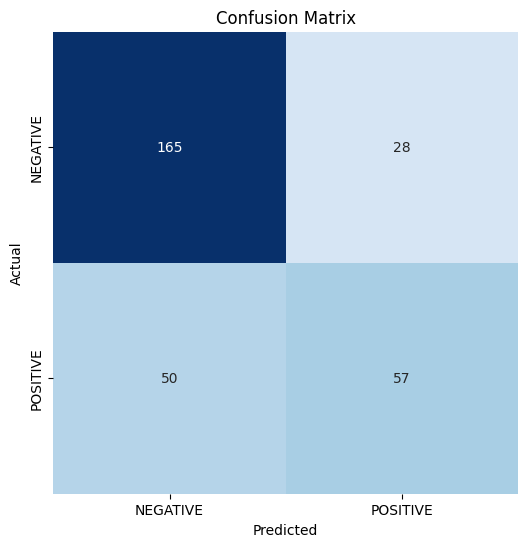

Classification Report :
......................
               precision    recall  f1-score   support

    NEGATIVE       0.77      0.85      0.81       193
    POSITIVE       0.67      0.53      0.59       107

    accuracy                           0.74       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.73      0.74      0.73       300



In [76]:
evaluate_model(model, test_data)